In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
import numpy as np
import xgboost as xgb
from joblib import dump
from src.models import eval_model as evm
from src.models import eval_baseline as evb
from sklearn.utils import resample
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve, f1_score, plot_confusion_matrix
from sklearn.model_selection import cross_val_score , cross_validate 
%load_ext autoreload
%autoreload 2

# Case for Down Sample

In [2]:
from sklearn.model_selection import train_test_split
def read_and_split_data(file):
    df = pd.read_csv(file)
    x=df.drop(['TARGET_5Yrs','TARGET_5Yrs_Inv'],axis=1)
    y=df['TARGET_5Yrs_Inv']
    x_data , x_test ,y_data,  y_test = train_test_split(x, y, test_size=0.2, random_state = 8, stratify=y)
    x_train , x_val , y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state = 8, stratify=y_data)
    print('y',y.value_counts())
    print('y_train',y_train.value_counts())
    print('y_val', y_val.value_counts())
    print('y_test',y_test.value_counts())
    return x_train , x_val , y_train, y_val, x_test,  y_test

In [3]:
x_train , x_val , y_train, y_val, x_test,  y_test = read_and_split_data("../data/processed/df_cleaned_downsampled_nba_prediction.csv")

y 0    1331
1    1331
Name: TARGET_5Yrs_Inv, dtype: int64
y_train 0    852
1    851
Name: TARGET_5Yrs_Inv, dtype: int64
y_val 0    213
1    213
Name: TARGET_5Yrs_Inv, dtype: int64
y_test 1    267
0    266
Name: TARGET_5Yrs_Inv, dtype: int64


In [4]:
space = {
    'max_depth': hp.choice('max_depth',range(1,100,1)),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.05),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 100, 1),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.05),
    'subsample' : hp.quniform('subsample', 0.1, 1, 0.05),
    'reg_lambda' : hp.quniform('reg_lambda', 0.1, 1, 0.05),
    'reg_alpha' : hp.quniform('reg_alpha', 0.1, 1, 0.05)
}
space

{'max_depth': <hyperopt.pyll.base.Apply at 0x2499c330130>,
 'learning_rate': <hyperopt.pyll.base.Apply at 0x249bdab5e50>,
 'min_child_weight': <hyperopt.pyll.base.Apply at 0x249bdab5fa0>,
 'colsample_bytree': <hyperopt.pyll.base.Apply at 0x249bdac5130>,
 'subsample': <hyperopt.pyll.base.Apply at 0x249bdac5280>,
 'reg_lambda': <hyperopt.pyll.base.Apply at 0x249bdac53d0>,
 'reg_alpha': <hyperopt.pyll.base.Apply at 0x249bdac5520>}

In [5]:
def objective(space):
   
    xgboost = xgb.XGBClassifier(
        random_state=8,
        max_depth = int(space['max_depth']),
        learning_rate = space['learning_rate'],
        min_child_weight = space['min_child_weight'],
        colsample_bytree = space['colsample_bytree'],
        subsample = space['subsample'],
        reg_lambda = space['reg_lambda'],
        reg_alpha = space['reg_alpha'],
        use_label_encoder=False
    )
    
    acc = cross_val_score(xgboost, x_train, y_train, cv=10, scoring="accuracy").mean()

    return{'loss': 1-acc, 'status': STATUS_OK }
best1 = fmin(
    fn=objective,   
    space=space,       
    algo=tpe.suggest,       
    max_evals=5
)
print("Best: ", best1)

[17:28:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:28:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:28:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:28:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:29:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


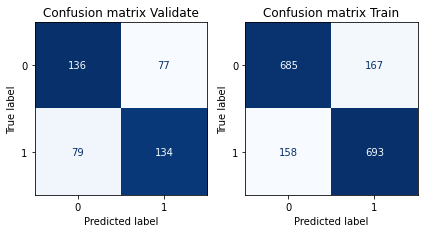

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.65, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=30,
              min_child_weight=21.0, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=8,
              reg_alpha=0.8500000000000001, reg_lambda=1.0, scale_pos_weight=1,
              subsample=1.0, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)


(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.65, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.1, max_delta_step=0, max_depth=30,
               min_child_weight=21.0, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=8,
               reg_alpha=0.8500000000000001, reg_lambda=1.0, scale_pos_weight=1,
               subsample=1.0, tree_method='exact', use_label_encoder=False,
               validate_parameters=1, verbosity=None),
 0.8928987162300084,
 0.6799025766492539)

In [6]:
xgboost1 = xgb.XGBClassifier(
    random_state=8,
    max_depth = int(best1['max_depth']),
    learning_rate = best1['learning_rate'],
    min_child_weight = best1['min_child_weight'],
    colsample_bytree = best1['colsample_bytree'],
    subsample = best1['subsample'],
    reg_lambda = best1['reg_lambda'],
    reg_alpha = best1['reg_alpha'],
    use_label_encoder=False
)
evm.eval_model(xgboost1,x_train,y_train,x_val,y_val)

In [7]:
def objective(space):
   
    xgboost = xgb.XGBClassifier(
        random_state=8,
        max_depth = int(space['max_depth']),
        learning_rate = space['learning_rate'],
        min_child_weight = space['min_child_weight'],
        colsample_bytree = space['colsample_bytree'],
        subsample = space['subsample'],
        reg_lambda = space['reg_lambda'],
        reg_alpha = space['reg_alpha'],
        use_label_encoder=False
    )
    
    acc = cross_val_score(xgboost, x_train, y_train, cv=10, scoring="roc_auc").mean()

    return{'loss': 1-acc, 'status': STATUS_OK }
best2 = fmin(
    fn=objective,   
    space=space,       
    algo=tpe.suggest,       
    max_evals=5
)
print("Best: ", best2)

[17:29:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:29:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:29:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:29:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:29:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


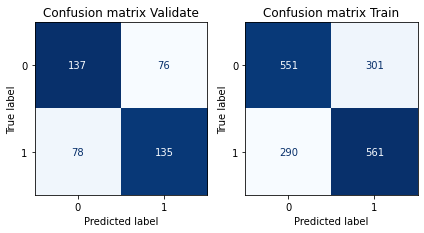

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=28,
              min_child_weight=46.0, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=8,
              reg_alpha=0.8500000000000001, reg_lambda=1.0, scale_pos_weight=1,
              subsample=0.30000000000000004, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)


(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.1, max_delta_step=0, max_depth=28,
               min_child_weight=46.0, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=8,
               reg_alpha=0.8500000000000001, reg_lambda=1.0, scale_pos_weight=1,
               subsample=0.30000000000000004, tree_method='exact',
               use_label_encoder=False, validate_parameters=1, verbosity=None),
 0.7109296988353939,
 0.684685578258282)

In [8]:
xgboost2 = xgb.XGBClassifier(
    random_state=8,
    max_depth = int(best2['max_depth']),
    learning_rate = best2['learning_rate'],
    min_child_weight = best2['min_child_weight'],
    colsample_bytree = best2['colsample_bytree'],
    subsample = best2['subsample'],
    reg_lambda = best2['reg_lambda'],
    reg_alpha = best2['reg_alpha'],
    use_label_encoder=False,
)
evm.eval_model(xgboost2,x_train,y_train,x_val,y_val)

In [9]:
def objective(space):
   
    xgboost = xgb.XGBClassifier(
        random_state=8,
        max_depth = int(space['max_depth']),
        learning_rate = space['learning_rate'],
        min_child_weight = space['min_child_weight'],
        colsample_bytree = space['colsample_bytree'],
        subsample = space['subsample'],
        reg_lambda = space['reg_lambda'],
        reg_alpha = space['reg_alpha'],
        use_label_encoder=False,
        objective ='binary:logistic'
    )
    
    acc = cross_val_score(xgboost, x_train, y_train, cv=10).mean()

    return{'loss': 1-acc, 'status': STATUS_OK }
best3 = fmin(
    fn=objective,   
    space=space,       
    algo=tpe.suggest,       
    max_evals=5
)
print("Best: ", best3)

[17:29:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:29:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:29:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:29:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:29:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


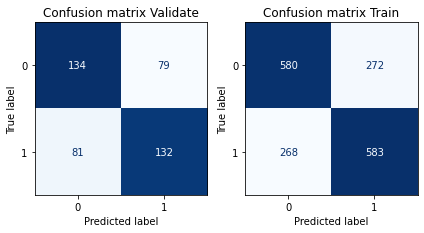

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.25, max_delta_step=0, max_depth=21,
              min_child_weight=70.0, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=8,
              reg_alpha=0.2, reg_lambda=0.35000000000000003, scale_pos_weight=1,
              subsample=0.65, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)


(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.25, max_delta_step=0, max_depth=21,
               min_child_weight=70.0, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=8,
               reg_alpha=0.2, reg_lambda=0.35000000000000003, scale_pos_weight=1,
               subsample=0.65, tree_method='exact', use_label_encoder=False,
               validate_parameters=1, verbosity=None),
 0.7443224761810188,
 0.6763979810002425)

In [10]:
xgboost3 = xgb.XGBClassifier(
    random_state=8,
    max_depth = int(best3['max_depth']),
    learning_rate = best3['learning_rate'],
    min_child_weight = best3['min_child_weight'],
    colsample_bytree = best3['colsample_bytree'],
    subsample = best3['subsample'],
    reg_lambda = best3['reg_lambda'],
    reg_alpha = best3['reg_alpha'],
    use_label_encoder=False,
    objective ='binary:logistic'
)
evm.eval_model(xgboost3,x_train,y_train,x_val,y_val)

In [11]:
def objective(space):
   
    xgboost = xgb.XGBClassifier(
        random_state=8,
        max_depth = int(space['max_depth']),
        learning_rate = space['learning_rate'],
        min_child_weight = space['min_child_weight'],
        colsample_bytree = space['colsample_bytree'],
        subsample = space['subsample'],
        reg_lambda = space['reg_lambda'],
        reg_alpha = space['reg_alpha'],
        use_label_encoder=False,
        objective ='binary:logistic',
        eval_metric ='auc'
    )
    
    acc = cross_val_score(xgboost, x_train, y_train, cv=10).mean()

    return{'loss': 1-acc, 'status': STATUS_OK }
best4 = fmin(
    fn=objective,   
    space=space,       
    algo=tpe.suggest,       
    max_evals=5
)
print("Best: ", best4)

100%|██████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.74s/trial, best loss: 0.3582456140350876]
Best:  {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 44.0, 'reg_alpha': 0.55, 'reg_lambda': 0.2, 'subsample': 0.35000000000000003}


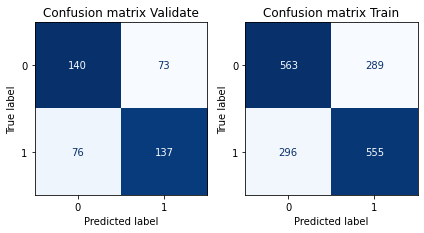

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=9, min_child_weight=44.0, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=8, reg_alpha=0.55,
              reg_lambda=0.2, scale_pos_weight=1, subsample=0.35000000000000003,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)


(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.9, eval_metric='auc',
               gamma=0, gpu_id=-1, importance_type='gain',
               interaction_constraints='', learning_rate=0.1, max_delta_step=0,
               max_depth=9, min_child_weight=44.0, missing=nan,
               monotone_constraints='()', n_estimators=100, n_jobs=8,
               num_parallel_tree=1, random_state=8, reg_alpha=0.55,
               reg_lambda=0.2, scale_pos_weight=1, subsample=0.35000000000000003,
               tree_method='exact', use_label_encoder=False,
               validate_parameters=1, verbosity=None),
 0.7180684971560661,
 0.6905926954528422)

In [12]:
xgboost4 = xgb.XGBClassifier(
    random_state=8,
    max_depth = int(best4['max_depth']),
    learning_rate = best4['learning_rate'],
    min_child_weight = best4['min_child_weight'],
    colsample_bytree = best4['colsample_bytree'],
    subsample = best4['subsample'],
    reg_lambda = best4['reg_lambda'],
    reg_alpha = best4['reg_alpha'],
    use_label_encoder=False,
    objective ='binary:logistic',
    eval_metric ='auc'
)
evm.eval_model(xgboost4,x_train,y_train,x_val,y_val)

# Validating the results

(0.6554729520430289,
 0.5984990619136961,
 0.5852713178294574,
 0.606425702811245,
 0.5655430711610487,
 0.5984990619136961)

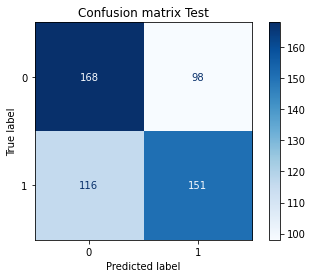

In [13]:
evm.get_performance(xgboost1, x_test, y_test, "Test", True)

(0.6744952268311227,
 0.626641651031895,
 0.6120857699805069,
 0.6382113821138211,
 0.5880149812734082,
 0.626641651031895)

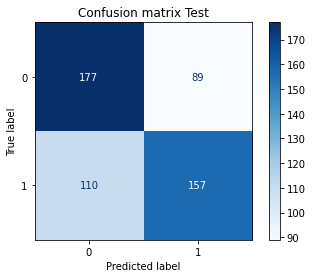

In [14]:
evm.get_performance(xgboost2, x_test, y_test, "Test", True)

(0.663280391991214,
 0.6041275797373359,
 0.5870841487279844,
 0.6147540983606558,
 0.5617977528089888,
 0.6041275797373359)

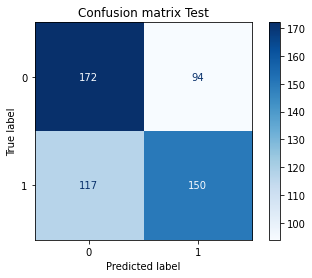

In [15]:
evm.get_performance(xgboost3, x_test, y_test, "Test", True)

(0.6819225028864295,
 0.6378986866791745,
 0.6178217821782178,
 0.6554621848739496,
 0.5842696629213483,
 0.6378986866791745)

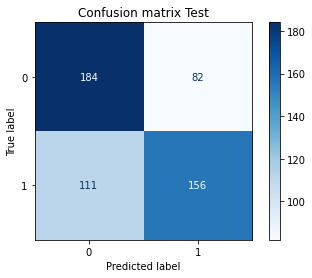

In [16]:
evm.get_performance(xgboost4, x_test, y_test, "Test", True)

In [34]:
def predict_extract_result(infile,mod,outfile):
    df = pd.read_csv(infile)
    df_cleaned = df.copy()
    print('Before Data Clean')
    for cols in df_cleaned.columns:
        chk_rows = df_cleaned[df_cleaned[cols]<0].shape[0]
        if chk_rows > 0 :
            print(f'Column Name {cols},\tRows with Negative Value {chk_rows},\tPercentage {chk_rows/len(df)*100}')
    df_cleaned[ df_cleaned<0 ] = 0
    df_cleaned.loc[df_cleaned['3P Made'] <= 0, ['3P Made', '3PA', 'CALC3P%']] = 0, 0, 0
    df_cleaned.loc[df_cleaned['FGM'] <= 0, ['FGM', 'FGA', 'CALCFG%']] = 0, 0, 0
    df_cleaned.loc[df_cleaned['FTM'] <= 0, ['FTM', 'FTA', 'CALCFT%']] = 0, 0, 0
    df_cleaned.loc[df_cleaned['3P Made'] > df_cleaned['3PA'], ['3P Made' , '3PA', 'CALC3P%']] = 0, 0, 0
    df_cleaned.loc[df_cleaned['FGM'] > df_cleaned['FGA'], ['FGM', 'FGA', 'CALCFG%']] = 0, 0, 0
    df_cleaned.loc[df_cleaned['FTM'] > df_cleaned['FTA'], ['FTM', 'FTA', 'CALCFT%']] = 0, 0, 0
    df_cleaned.loc[df_cleaned['3P Made'] > 0, ['CALC3P%']] = df_cleaned['3P Made']/df_cleaned['3PA']*100
    df_cleaned.loc[df_cleaned['FGM'] > 0, ['CALCFG%']] =df_cleaned['FGM']/df_cleaned['FGA']*100
    df_cleaned.loc[df_cleaned['FTM'] > 0, ['CALCFT%']] = df_cleaned['FTM']/df_cleaned['FTA']*100
    print(df_cleaned.head(5))
    print('After Data Clean')
    for cols in df_cleaned.columns:
        chk_rows = df_cleaned[df_cleaned[cols]<0].shape[0]
        if chk_rows > 0 :
            print(f'Column Name {cols},\tRows with Negative Value {chk_rows},\tPercentage {chk_rows/len(df)*100}')
    x = df_cleaned.drop(['3P%','FT%','FG%','Id_old','Id'],axis=1)
    print(df_cleaned.columns)
    y_pred_proba=mod.predict_proba(x)
    y_pred=mod.predict(x)
    print(np.unique(y_pred,return_counts=True))
    df_cleaned_result = df_cleaned.copy()
    df_cleaned_result['TARGET_5Yrs'] = y_pred_proba[:,0]
    print(df_cleaned_result['TARGET_5Yrs'].round().value_counts())
    df_cleaned_result.to_csv(outfile,index=False,columns=['Id', 'TARGET_5Yrs'])
    return x

In [35]:
df=predict_extract_result('../data/raw/test.csv',xgboost1,'../data/processed/TestResult_XG_DownSample.csv')

Before Data Clean
Column Name 3P Made,	Rows with Negative Value 775,	Percentage 20.400105290866016
Column Name 3PA,	Rows with Negative Value 773,	Percentage 20.34745985785733
Column Name 3P%,	Rows with Negative Value 435,	Percentage 11.450381679389313
Column Name BLK,	Rows with Negative Value 456,	Percentage 12.003158725980521
   Id_old  Id  GP   MIN   PTS  FGM   FGA   FG%  3P Made  3PA  ...  OREB  DREB  \
0       1   0  56   9.1   4.0  1.6   3.7  43.7      0.1  0.3  ...   1.2   0.8   
1    8194   1  43  19.3  10.1  3.7   8.1  46.0      0.6  1.7  ...   0.5   0.9   
2       3   2  82  33.9  11.3  4.9  10.6  45.6      0.5  1.9  ...   1.3   3.3   
3    8196   3  86  44.7  18.8  6.8  15.9  42.9      0.5  1.8  ...   1.5   3.2   
4    8197   4  58  12.3   4.7  1.6   4.0  40.0      0.5  1.7  ...   0.2   0.6   

   REB  AST  STL  BLK  TOV    CALC3P%    CALCFG%    CALCFT%  
0  1.7  0.4  0.2  0.3  0.8  33.333333  43.243243  58.333333  
1  1.5  3.5  0.6  0.0  1.8  35.294118  45.679012  72.000000 

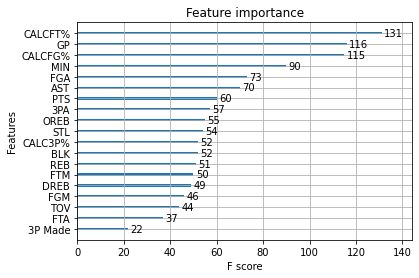

In [19]:
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(xgboost1)
pyplot.show()